This notebook is part of the ``deepcell-tf`` documentation: https://deepcell.readthedocs.io/.

# Multiplex cell segmentation

In [1]:
# Download multiplex data
import deepcell
import numpy as np
from sklearn.model_selection import train_test_split

#with urllib.request.urlopen('https://deepcell-data.s3.amazonaws.com/multiplex/20200810_tissue_dataset.npz') as f:
   # html = f.read().decode('utf-8')


filename = '20200810_tissue_dataset.npz'
test_size = 0.1 # % of data saved as test
seed = 0 # seed for random train-test split

a = np.load(filename)

print(a.files)

a['X'].shape
a['y'].shape

X_train, X_test, y_train, y_test = train_test_split(a['X'], a['y'], test_size=0.10, random_state=26)


['X', 'y']


In [2]:
# select one of the images to display
i = 4
im = X_train[i:(i + 1)]
im.shape

#from matplotlib import pyplot as plt
#plt.imshow(im[0, ..., 0])
#plt.show()

(1, 512, 512, 2)

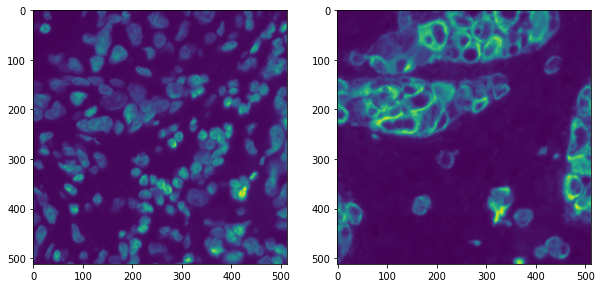

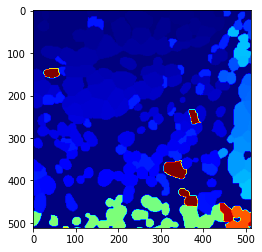

In [3]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(im[0, ..., 0])
ax[1].imshow(im[0, ..., 1])
plt.show()


plt.imshow(y_train[i:(i+1)][0, ..., 0], cmap = 'jet')

## Whole Cell Segmentation

### Initialize multiplex model

The application will download pretrained weights for tissue segmentation. For more information about application objects, please see our [documentation](https://deepcell.readthedocs.io/en/master/API/deepcell.applications.html).

In [ ]:
from deepcell.applications import MultiplexSegmentation
app = MultiplexSegmentation()

W0827 20:11:29.344602 140394103125824 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


104611840/104607160 [==============================] - 64s 1us/step


## Use the application to generate labeled images

Typically, neural networks perform best on test data that is similar to the training data. In the realm of biological imaging, the most common difference between datasets is the resolution of the data measured in microns per pixel. The training resolution of the model can be identified using `app.model_mpp`.

In [ ]:
print('Training Resolution:', app.model_mpp, 'microns per pixel')

The resolution of the input data can be specified in `app.predict` using the `image_mpp` option. The `Application` will rescale the input data to match the training resolution and then rescale to the original size before returning the labeled image.

In [ ]:
labeled_im = app.predict(im, image_mpp=2.0)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(im[0, ..., 0])
ax[1].imshow(im[0, ..., 1])
ax[2].imshow(labeled_im[0, ..., 0], cmap='jet')
plt.show()

In [ ]:
i = 0
test_im = X_test[i:(i+1)]
test_im.shape
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(test_im[0, ..., 0])
ax[1].imshow(test_im[0, ..., 1])
plt.show()

In [ ]:
labeled_test_im = app.predict(test_im, image_mpp=2.0)

In [ ]:
plt.imshow(labeled_test_im[0,...,0], cmap = 'jet')

In [ ]:
from deepcell import image_generators
from deepcell.utils import train_utils

transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}

batch_size = 1
min_objects = 1

# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

In [ ]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]

fig, axes = plt.subplots(1, 4, figsize=(15, 15))

axes[0].imshow(img[..., 0])
axes[0].set_title('Source Image')

axes[1].imshow(inner_distance[0, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, ..., 0])
axes[3].set_title('Foreground/Background')

plt.show()


In [ ]:

coords = peak_local_max(
    inner_distance[index],
    min_distance=10,
    threshold_abs=0.1,
    exclude_border=False)

fig, axes = plt.subplots(1, 3, figsize=(20, 20))

axes[0].imshow(X_train[index, ..., 0])
axes[0].scatter(coords[..., 1], coords[..., 0],
                color='r', marker='.', s=10)
axes[1].imshow(inner_distance[index, ..., 0], cmap='jet')
axes[2].imshow(outer_distance[index, ..., 0], cmap='jet')


## Nuclear Cell Segmentation (Ask about Compartment)

In addition to predicting whole-cell segmentation, this application can also be used for nuclear predictions

In [ ]:
labeled_nuc_im = app.predict(im, image_mpp=2.0, compartment = 'both')
labeled_nuc_im.shape

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(im[0, ..., 0])
ax[1].imshow(im[0, ..., 1])
ax[2].imshow(labeled_nuc_im[0, ..., 0], cmap='jet')
plt.show()